<a href="https://colab.research.google.com/github/zuzking/Debate/blob/main/Copy_of_NLP_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP
The 2020 Democratic Third Democratic Presidential Primary Debate,September 12, 2019, Houston, Texas. 

Source:
https://www.washingtonpost.com/politics/2019/09/13/transcript-third-democratic-debate/

* Loaded the third 2020 Democratic presidential primary debate 
transcript

* Cleaned and stemmed the text data and applied unsupervised learning methods for topic clustering and semantic analysis

* Visualized candidates’ high frequency and overlapped words in debate. 

* Applied TF-IDF and LDA topic cluster methods and classified the whole transcript into 4 categories and listed the relevant words for each topic

* Utilized semantic analysis, and acquired the subjectivity and polarity score, to analysis the candidates' emotions.

* Part 1: Load Data
* Part 2: Tokenizing and Stemming
* Part 3: Words and Sentence Analysis 
* Part 4: TF-IDF & K-means clustering
* Part 5: Topic Modeling - Latent Dirichlet Allocation
* Part 6: Semantic Analysis 

# Environment

In [ ]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd

import nltk
import gensim
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

from flair.models import TextClassifier
classifier = TextClassifier.load('en-sentiment')
from flair.data import Sentence

# For analyzing text
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import nltk
import string
import regex as re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter 
# some additional pucntuations observed in the dataset
punc = '’”“…'.join(string.punctuation)
# Import VADER sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("n't")
stopwords.append("br")


2022-10-10 03:01:04,731 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving text.csv to text (1).csv


In [ ]:
f = open("text.csv", encoding="ISO-8859-1")
df=pd.read_csv(f)

In [ ]:
df.head()

,speaker,text,Unnamed: 2,Unnamed: 3
0,ANNOUNCER,This is an ABC News special.,NaN,NaN
1,BIDEN,I will be a president for every American.,NaN,NaN
2,WARREN,This is our moment.,NaN,NaN
3,SANDERS,We are in a struggle for the future of this co...,NaN,NaN
4,HARRIS,We fight for our country. That's the nature of...,NaN,NaN


In [ ]:
data = df.iloc[0:377,0:2]
data["speaker"].unique()

array(['ANNOUNCER', 'BIDEN', 'WARREN', 'SANDERS', 'HARRIS', 'YANG',
       'BOOKER', 'O¡¯ROURKE', 'KLOBUCHAR', 'CASTRO', 'STEPHANOPOULOS',
       'RAMOS', 'DAVIS', 'MUIR', 'BUTTIGIEG', '(COMMERCIAL BREAK)'],
      dtype=object)

In [ ]:
# Poll results 
poll_data = {'Name': ['BIDEN', 'SANDERS', 'WARREN', 'HARRIS',"BUTTIGIEG", "YANG", "O¡¯ROURKE",\
                 'BOOKER', 'KLOBUCHAR', 'CASTRO'], \
        'poll': [0.268, 0.173, 0.168, 0.065, 0.048, 0.030, 0.028, 0.023, 0.012, 0.010]}  
poll = pd.DataFrame(poll_data)
poll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    10 non-null     object 
 1   poll    10 non-null     float64
dtypes: float64(1), object(1)
memory usage: 288.0+ bytes


In [ ]:
poll.head()

,Name,poll
0,BIDEN,0.268
1,SANDERS,0.173
2,WARREN,0.168
3,HARRIS,0.065
4,BUTTIGIEG,0.048


In [ ]:

c = ['BIDEN', 'WARREN', 'SANDERS', 'HARRIS', 'YANG',
       'BOOKER', 'O¡¯ROURKE', 'KLOBUCHAR', 'CASTRO','BUTTIGIEG']
spk = data[data.speaker.isin(c)]
spk["speaker"].unique()
# top 4 candidates  
BIDEN = data[data.speaker == 'BIDEN']
WARREN = data[data.speaker == 'WARREN']
SANDERS = data[data.speaker == 'SANDERS']
HARRIS = data[data.speaker == 'HARRIS']

In [ ]:
# figure out each speaker spoke how many sentences
spk['num_sents'] = spk.text.apply(lambda x:len(sent_detector.tokenize(x)))
spk.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,speaker,text,num_sents
1,BIDEN,I will be a president for every American.,1
2,WARREN,This is our moment.,1
3,SANDERS,We are in a struggle for the future of this co...,1
4,HARRIS,We fight for our country. That's the nature of...,2
5,SANDERS,Right now we can act.,1


In [ ]:
num_sents = spk.groupby(['speaker']).sum()[['num_sents']].reset_index()
total_sents = num_sents.sum().num_sents
num_sents.loc[:, 'precentage'] = num_sents.num_sents.apply(lambda x:round(x/total_sents, 2))
num_sents

,speaker,num_sents,precentage
0,BIDEN,222,0.21
1,BOOKER,128,0.12
2,BUTTIGIEG,76,0.07
3,CASTRO,109,0.10
4,HARRIS,96,0.09
5,KLOBUCHAR,98,0.09
6,O¡¯ROURKE,57,0.05
7,SANDERS,66,0.06
8,WARREN,147,0.14
9,YANG,72,0.07


In [ ]:
num_sents

,speaker,num_sents,precentage
0,BIDEN,222,0.21
1,BOOKER,128,0.12
2,BUTTIGIEG,76,0.07
3,CASTRO,109,0.10
4,HARRIS,96,0.09
5,KLOBUCHAR,98,0.09
6,O¡¯ROURKE,57,0.05
7,SANDERS,66,0.06
8,WARREN,147,0.14
9,YANG,72,0.07


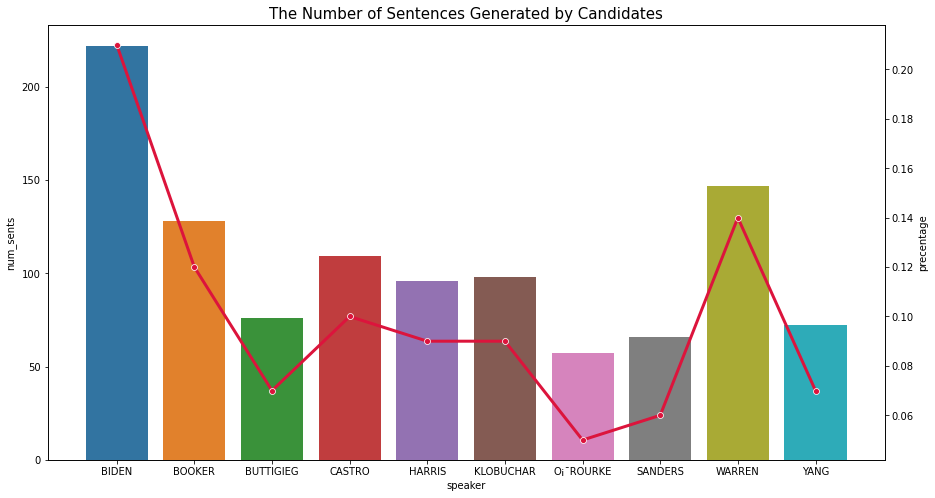

In [ ]:
plt.figure(figsize=(15, 8))
num_sents = pd.DataFrame(num_sents)
ax = sns.barplot(data = num_sents, x = 'speaker', y = 'num_sents')

ax2 = ax.twinx()
sns.lineplot(x='speaker', y='precentage', data=num_sents, marker='o', color='crimson', lw=3, ax=ax2)
plt.title("The Number of Sentences Generated by Candidates",fontsize='15', color='Black')

plt.show()

In [ ]:
# merge with poll data
sent_poll = pd.merge(num_sents, poll, left_on = 'speaker', right_on = 'Name', how = 'inner' )
#sent_poll = pd.concat([poll, num_sents], axis = 1, join="inner")

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


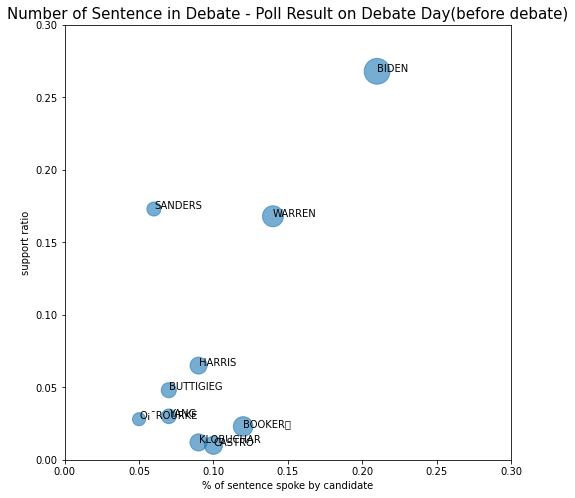

In [ ]:
name = np.array(['BIDEN', 'BOOKER	', 'BUTTIGIEG', 'CASTRO', 'HARRIS', 'KLOBUCHAR', 'O¡¯ROURKE', 'SANDERS', 'WARREN', 'YANG'])
plt.scatter(sent_poll['precentage'], sent_poll['poll'], cmap = name, s = sent_poll['num_sents']*3, alpha=0.6)

for i in range(len(name)):
    plt.annotate(name[i], (sent_poll['precentage'][i], sent_poll['poll'][i]))
plt.ylabel('support ratio')
plt.xlabel('% of sentence spoke by candidate')
plt.title("Number of Sentence in Debate - Poll Result on Debate Day(before debate)",fontsize='15', color='Black')
plt.xlim((0, 0.3))
plt.ylim((0, 0.3))
plt.gcf().set_size_inches(8,8)
plt.show()

# Words level analysis

Sentence cleaning

In [ ]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("n't")
stopwords.append("br")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:183])


We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not

In [ ]:
# customize stopwords 
custom_st = ['a','the', 'and', 'there', 'that', 'this', 'am', 'on',
                       'if', 'it', 'to', 'at' 'a', 'of', 'in', 'out', 'were',
                       'was', 'do', 'did', "don't","didn't", 'be', 'are', 'is',
                       'being', "it's", 'have', 'had', 's', 'j', 't', 're',
                       'at', 'with', 'just', 'now', "can't", 'can', 'up',
                       'as', 'from', 'thing', 'by', 'so', 'here', 'will', 'for',
                   '.', ',', '’', '?', '[', ']', '…', 'going', 'want', 'know', 'look', 
                   'would', 'said', 'got', 'think', 'say', 'tell', 'go', 'get', 
                    'crosstalk', 'well', 'like', 'much', 'make']
total_stop = stopwords + custom_st

In [ ]:
len(total_stop)

254

In [ ]:
# Spacy packages
sp = spacy.load('en_core_web_sm') 
spacy_st = list(nlp.Defaults.stop_words) # 362 stop words 
# NLTK packages
nltk.download('stopwords')
nltk.download('punkt')
#nltk_st = stopwords.words('english') # 179 stop words

# some additional pucntuations observed in the dataset
punc = '’”“…'.join(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# text cleaning funcion
def clean(t, lower = False, http = False, punct = False,
          lem = False, stop_w = False, num = False):
    if lower:
        t = t.lower()
    if http:
        t = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', t)
    # lemmitizing
    if lem:
        # spacy replaces pronouns with '-PRON-' and we don't want that to happen
        # so we lemmatize everything exept words that are recognized as pronouns
        lemmatized = [word.lemma_ if word.lemma_ !='-PRON-' else word.text for word in sp(t)]
        t = ' '.join(lemmatized)
    # punctuation removal
    if punct:
        t = t.translate(str.maketrans('', '', punc))
    if num:
        t = re.sub("[0-9]","", t)
    # removing extra spaces and letters
    t = re.sub("\s+", ' ', t)
    t = re.sub("\b\w\b", '', t)
    return t

In [ ]:
spk['cleaned_text'] = spk.text.apply(lambda x: clean(x, lower = True, http = False,
                                                         punct = True, lem = True, 
                                                         stop_w = True, num = True ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
spk.head(3)

,speaker,text,num_sents,cleaned_text
1,BIDEN,I will be a president for every American.,1,I will be a president for every american
2,WARREN,This is our moment.,1,this be our moment
3,SANDERS,We are in a struggle for the future of this co...,1,we be in a struggle for the future of this cou...


Stemming on cleaned text

In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in total_stop:
            tokens.append(word.lower())
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [ ]:
spk['stem_words'] = spk['cleaned_text'].apply(lambda x: tokenization_and_stemming(x))
spk['stem_sent'] = spk['stem_words'].apply(lambda x: ' '.join(x))
spk['words'] = spk.cleaned_text.apply(lambda x:x.split())
spk.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,speaker,text,num_sents,cleaned_text,stem_words,stem_sent,words
1,BIDEN,I will be a president for every American.,1,I will be a president for every american,"[presid, everi, american]",presid everi american,"[I, will, be, a, president, for, every, american]"
2,WARREN,This is our moment.,1,this be our moment,[moment],moment,"[this, be, our, moment]"
3,SANDERS,We are in a struggle for the future of this co...,1,we be in a struggle for the future of this cou...,"[struggl, futur, countri]",struggl futur countri,"[we, be, in, a, struggle, for, the, future, of..."
4,HARRIS,We fight for our country. That's the nature of...,2,we fight for our country that be the nature of...,"[fight, countri, natur]",fight countri natur,"[we, fight, for, our, country, that, be, the, ..."
5,SANDERS,Right now we can act.,1,right now we can act,"[right, act]",right act,"[right, now, we, can, act]"
6,YANG,We're in the midst of the greatest economic tr...,1,we be in the midst of the great economic trans...,"[midst, great, econom, transform]",midst great econom transform,"[we, be, in, the, midst, of, the, great, econo..."
7,BOOKER,We have overcome worse times and darker momen...,1,we have overcome bad time and dark moment tha...,"[overcom, bad, time, dark, moment]",overcom bad time dark moment,"[we, have, overcome, bad, time, and, dark, mom..."
8,O¡¯ROURKE,We will make the most of this moment that we ...,1,we will make the most of this moment that we ...,"[moment, togeth]",moment togeth,"[we, will, make, the, most, of, this, moment, ..."
9,KLOBUCHAR,We are on a march together.,1,we be on a march together,"[march, togeth]",march togeth,"[we, be, on, a, march, together]"
10,CASTRO,We're going to win by being bold. We're going...,2,we be go to win by be bold we be go to win by...,"[win, bold, win, fearless]",win bold win fearless,"[we, be, go, to, win, by, be, bold, we, be, go..."


## Find out the top frequency words

####After stemming  on a cleaned text 

In [ ]:
def most_common(df, name, top_n):
    list_ = []
    for w in df[df.speaker == name].stem_words:
        list_.extend(w)
    Counter_1 = Counter(list_) 
    most_occured = Counter_1.most_common(top_n)
    
    data = pd.DataFrame(most_occured, columns = ['word', 'frequency'] )
    return data

In [ ]:
# top 50 frequency words 
WARREN  = most_common(spk, 'WARREN', 50)   
BIDEN = most_common(spk, 'BIDEN', 50)   
SANDERS = most_common(spk, 'SANDERS', 50)
HARRIS = most_common(spk, 'HARRIS',50)
YANG = most_common(spk, 'YANG',50)

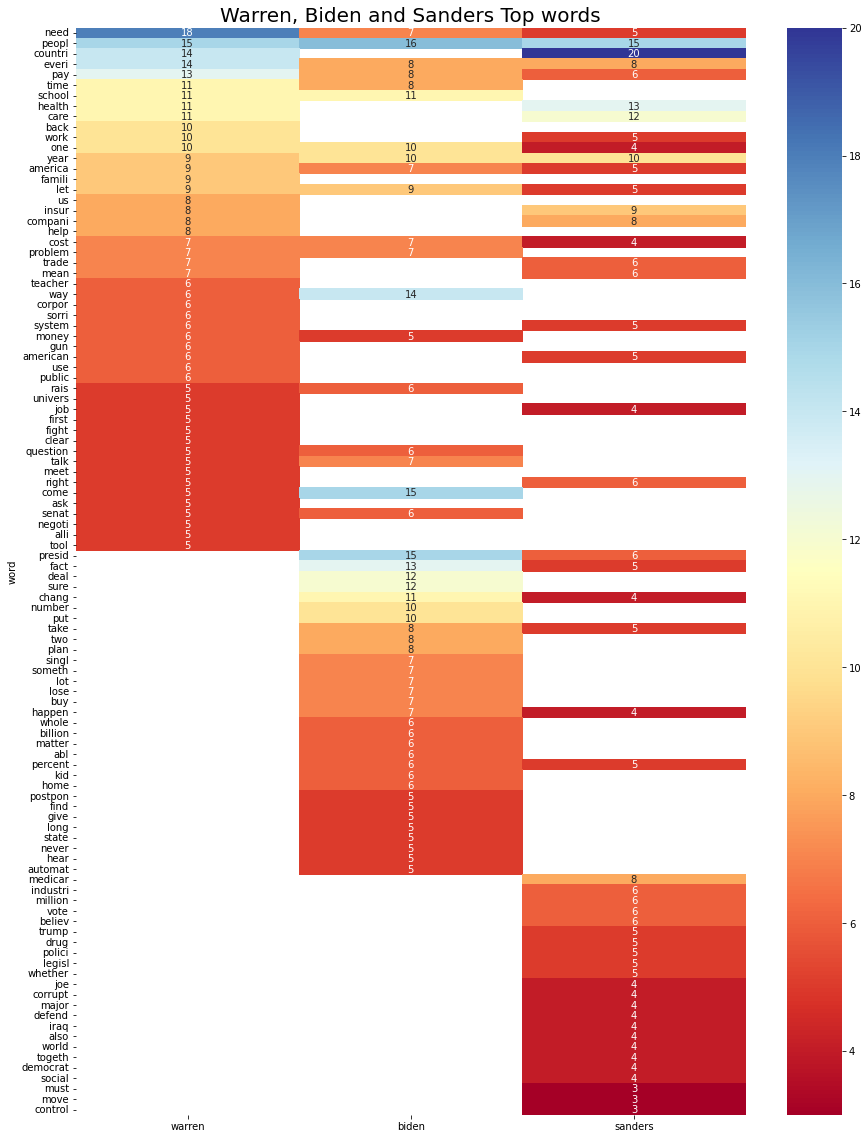

In [ ]:
from functools import reduce
data_frame = [WARREN, BIDEN, SANDERS]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['word'],
                                            how='outer'), data_frame)
df_mergeinn =  reduce(lambda  left,right: pd.merge(left,right,on=['word'],
                                            how='inner'), data_frame)

df_merged.columns = ['word', 'warren', 'biden','sanders']
df_merged1 = df_merged.set_index('word')


sns.heatmap(df_merged1,annot=True,annot_kws={'size':10},xticklabels=True, yticklabels=True,cmap='RdYlBu')

plt.title('Warren, Biden and Sanders Top words', fontsize = 20) 

plt.gcf().set_size_inches(15,20)

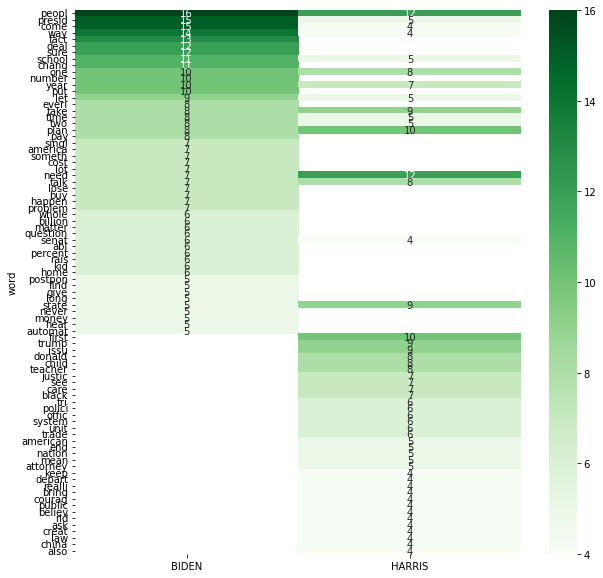

In [ ]:
# Biden and Harris overlapped words 
bh = BIDEN.merge(HARRIS, left_on = 'word', right_on='word', how = 'outer')
bh.columns = ['word','BIDEN', 'HARRIS']
bh = bh.set_index('word')
sns.heatmap(bh,annot=True,annot_kws={'size':10},cmap='Greens',xticklabels=True, yticklabels=True)
plt.gcf().set_size_inches(10,10)

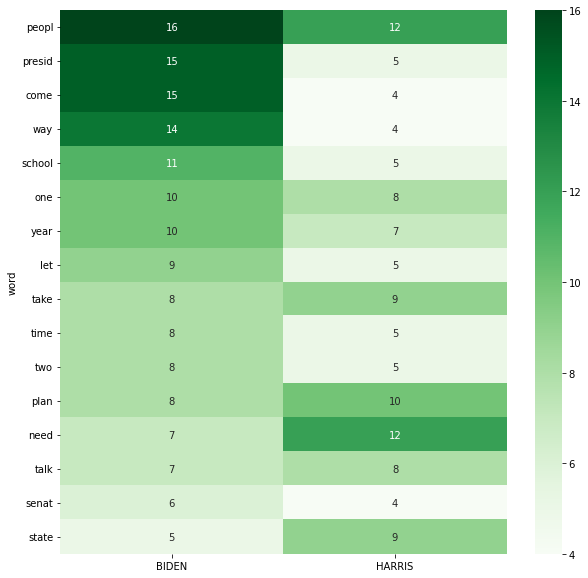

In [ ]:
bhinn = BIDEN.merge(HARRIS, left_on = 'word', right_on='word', how = 'inner')
bhinn.columns = ['word','BIDEN', 'HARRIS']
bhinn = bhinn.set_index('word')
sns.heatmap(bhinn,annot=True,annot_kws={'size':10},cmap='Greens',xticklabels=True, yticklabels=True)
plt.gcf().set_size_inches(10,10)

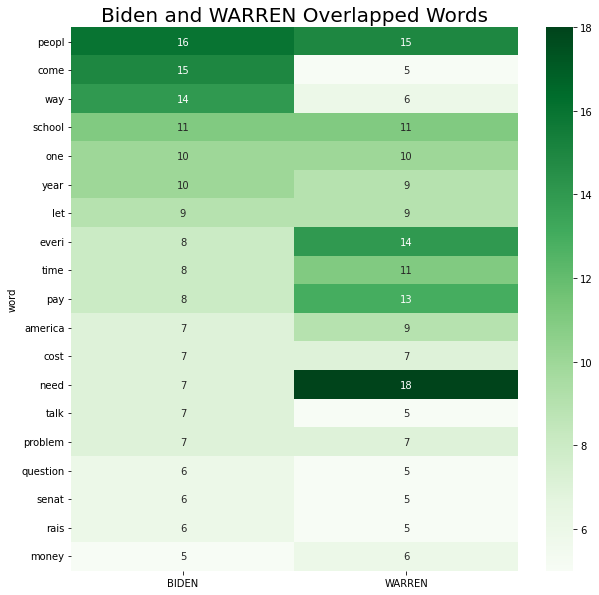

In [ ]:
bwinn = BIDEN.merge(WARREN, left_on = 'word', right_on='word', how = 'inner')
bwinn.columns = ['word','BIDEN', 'WARREN']
bwinn = bwinn.set_index('word')
sns.heatmap(bwinn,annot=True,annot_kws={'size':10},cmap='Greens',xticklabels=True, yticklabels=True)
plt.title('Biden and WARREN Overlapped Words', fontsize = 20) 
plt.gcf().set_size_inches(10,10)

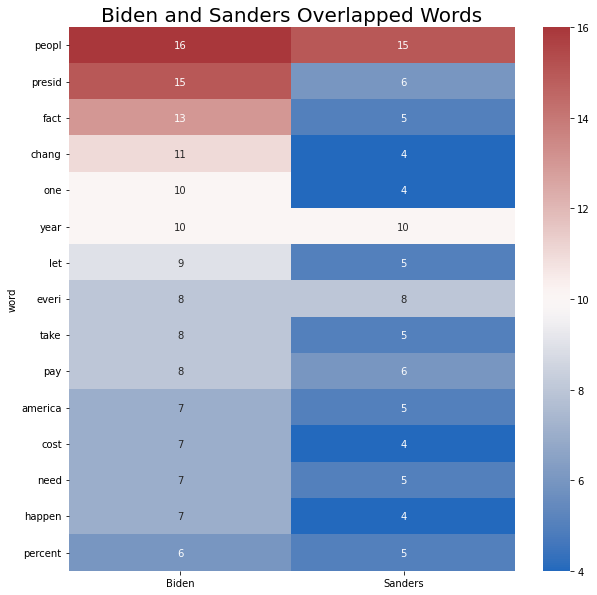

In [ ]:
bsinn = BIDEN.merge(SANDERS, left_on = 'word', right_on='word', how = 'inner')
bsinn.columns = ['word','Biden', 'Sanders']
bsinn = bsinn.set_index('word')
sns.heatmap(bsinn,annot=True,annot_kws={'size':10},cmap='vlag',xticklabels=True, yticklabels=True)
plt.title('Biden and Sanders Overlapped Words', fontsize = 20) 
plt.gcf().set_size_inches(10,10)

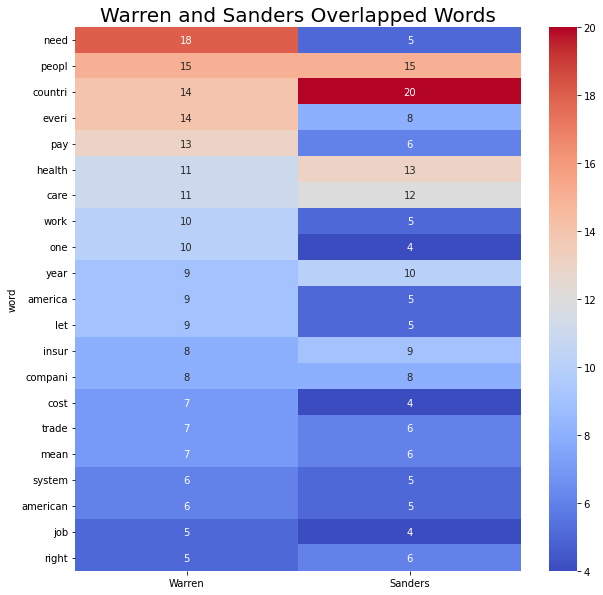

In [ ]:
swinn = WARREN.merge(SANDERS, left_on = 'word', right_on='word', how = 'inner')
swinn.columns = ['word','Warren', 'Sanders']
swinn = swinn.set_index('word')
sns.heatmap(swinn,annot=True,annot_kws={'size':10},cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('Warren and Sanders Overlapped Words', fontsize = 20) 

plt.gcf().set_size_inches(10,10)

In [ ]:
# inner join for 'warren', 'biden','sanders','harris','yang'
df_mergeinn1 = df_mergeinn.set_index('word')
df_mergeinn1.columns = ['warren', 'biden','sanders']

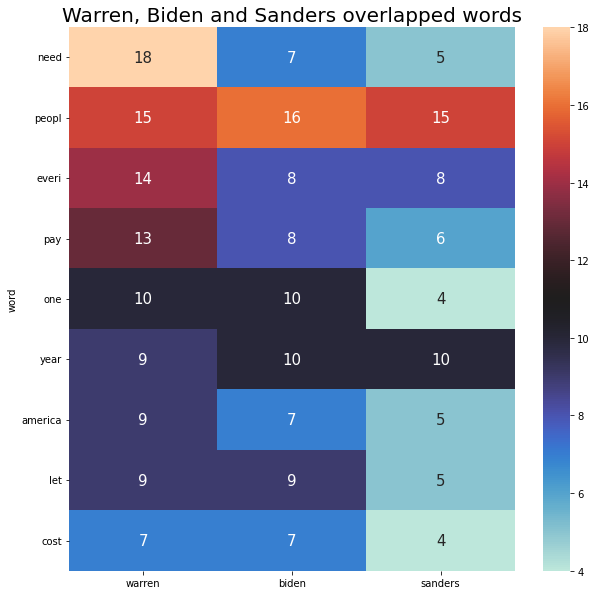

In [ ]:
sns.heatmap(df_mergeinn1,annot=True,annot_kws={'size':15},cmap='icefire')
plt.title('Warren, Biden and Sanders overlapped words', fontsize = 20) 
plt.gcf().set_size_inches(10,10)

In [ ]:
'''
flatui = ["#9b59b6", "#3498db"]
f, ax = plt.subplots(figsize=(30, 30))
sns.barplot(x = df_merged['word'], y = df_merged['warren'], label='warren',   color=sns.color_palette("Set2", 10)[0])
sns.barplot(x = df_merged['word'], y = df_merged['biden'], label='biden',   color=sns.color_palette("Set2", 10)[1])
'''

Text(0.5, 1.0, 'Biden top frequency words_stem')

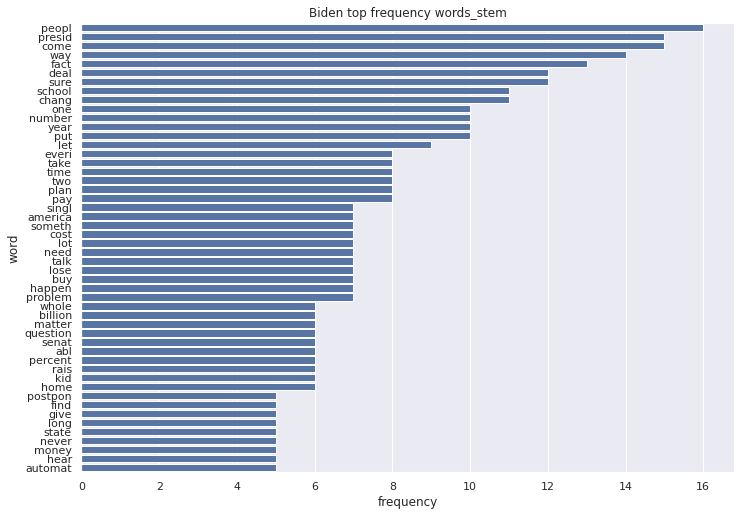

In [ ]:
# NO.1 support rate Biden words 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=BIDEN, y=BIDEN['word'], x=BIDEN['frequency'], color = 'b').set_title('Biden top frequency words_stem')
#sns.barplot(data=WARREN, y='word', x='frequency', color = 'b').set_title('Warren top frequency words_stem')

Text(0.5, 1.0, 'Warren top frequency words_stem')

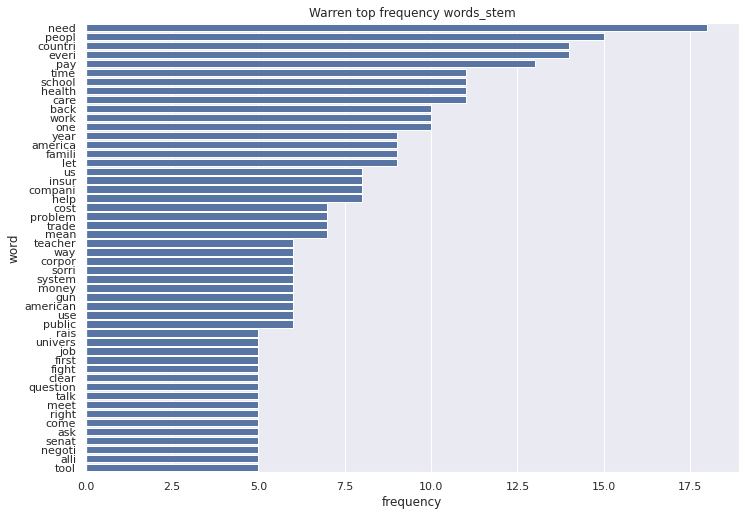

In [ ]:
sns.barplot(data=WARREN, y='word', x='frequency', color = 'b').set_title('Warren top frequency words_stem')

Text(0.5, 1.0, 'Sanders top frequency words_stem')

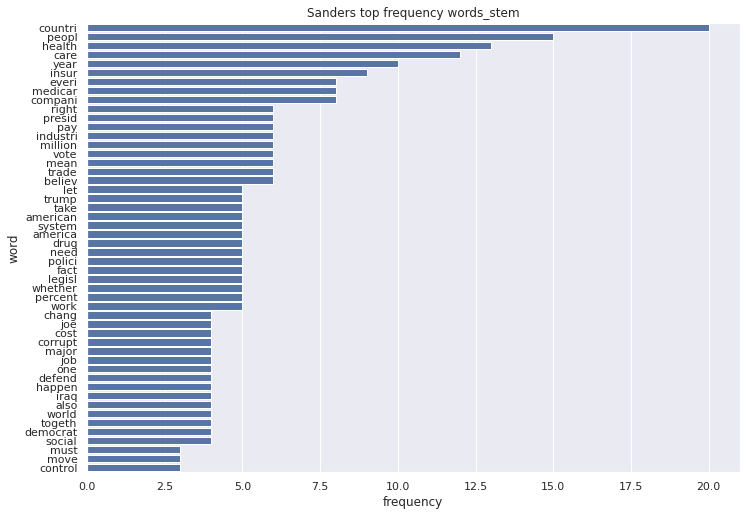

In [ ]:
sns.barplot(data=SANDERS, y='word', x='frequency', color = 'b').set_title('Sanders top frequency words_stem')

In [ ]:
# Biden speech  
def filter_spk(data, name):
  return data[data.speaker == name]
filter_spk(spk, "BIDEN").head(3)

,speaker,text,num_sents,cleaned_text,stem_words,stem_sent,words
1,BIDEN,I will be a president for every American.,1,I will be a president for every american,"[presid, everi, american]",presid everi american,"[I, will, be, a, president, for, every, american]"
35,BIDEN,"You know, when President Kennedy announced th...",10,you know when president kennedy announce the ...,"[presid, kennedi, announc, moon, shot, use, ph...",presid kennedi announc moon shot use phrase st...,"[you, know, when, president, kennedy, announce..."
37,BIDEN,That will be for the voters to decide that qu...,15,that will be for the voter to decide that que...,"[voter, decid, question, let, debat, health, c...",voter decid question let debat health care sen...,"[that, will, be, for, the, voter, to, decide, ..."


In [ ]:
spk_text = spk.loc[:, 'cleaned_text'].tolist() 

In [ ]:
data = spk.loc[:, 'text'].tolist()

In [ ]:
'''
BIDEN_list = BIDEN.loc[:, 'text'].tolist()
WARREN_list = WARREN.loc[:, 'text'].tolist()
SANDERS_list = SANDERS.loc[:, 'text'].tolist()
HARRIS_list = HARRIS.loc[:, 'text'].tolist()
'''

# Topic Clustering 
#### Unsupervised learning methods TF-IDF with k-mean and LDA clustering 

####TF-IDF Method

In [ ]:
spk_text = spk.loc[:, 'cleaned_text'].tolist() 

from sklearn.feature_extraction.text import TfidfVectorizer
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(spk_text) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  % sorted(inconsistent)


In total, there are 189 reviews and 906 terms.


In [ ]:
# k-means clustering
from sklearn.cluster import KMeans

#num_clusters = 4

# number of clusters
km = KMeans(n_clusters=4)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
# create DataFrame films from all of the input files.
product = { 'text': spk_text, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['text', 'cluster'])
frame.head(100)

,text,cluster
0,I will be a president for every american,3
1,this be our moment,0
2,we be in a struggle for the future of this cou...,1
3,we fight for our country that be the nature of...,1
4,right now we can act,0
...,...,...
95,I so appreciate what the congressman be be do...,0
96,so if we want to get something do and I perso...,0
97,because we can not spare another innocent life,0
98,so background check and gun licensing these b...,3


In [ ]:
print ("Number of reviews included in each cluster(TF-IDF):")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster(TF-IDF):


,cluster
0,92
3,64
1,26
2,7


### LDA method for topic clustering

In [ ]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components= 4)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

tfidf_model_lda = CountVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix_lda = tfidf_model_lda.fit_transform(spk_text) #fit the vectorizer to synopses  

print ("In total, there are " + str(tfidf_matrix_lda.shape[0]) + \
      " reviews and " + str(tfidf_matrix_lda.shape[1]) + " terms.")

lda_output = lda.fit_transform(tfidf_matrix_lda)
print(lda_output.shape)
print(lda_output)

# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(spk_text))] ### enter the LIST 

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(100)

# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(spk_text))] ### enter the LIST 

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

#df_document_topic.head(20)

In [ ]:
print ("Number of reviews included in each cluster(LDA):")
df_document_topic['topic'].value_counts().to_frame()

Number of reviews included in each cluster(LDA):


,topic
2,78
0,45
3,36
1,30


In [ ]:
# use majority vote figure out topic number 
df_document_topic.head(3)

,Topic0,Topic1,Topic2,Topic3,topic
Doc0,0.07,0.06,0.80,0.07,2
Doc1,0.62,0.13,0.13,0.13,0
Doc2,0.07,0.07,0.07,0.80,3


In [ ]:
lda_topic = pd.DataFrame(df_document_topic['topic'])
lda_topic.index = range(len(lda_topic))
spk.index = range(len(spk))
final = pd.concat([spk, lda_topic], axis=1)

In [ ]:
#check topic text e.g. topic 2 
final[final['topic'] == 2].head(3)

,speaker,text,num_sents,cleaned_text,stem_words,stem_sent,words,scores_flair,pred_flair,polarity,subjectivity,topic
0,BIDEN,I will be a president for every American.,1,I will be a president for every american,"[presid, everi, american]",presid everi american,"[I, will, be, a, president, for, every, american]",0.997806,POSITIVE,0.000000,0.000000,2
4,SANDERS,Right now we can act.,1,right now we can act,"[right, act]",right act,"[right, now, we, can, act]",0.999276,POSITIVE,0.285714,0.535714,2
11,KLOBUCHAR,"Good evening, Texas Southern. I believe that ...",13,good evening texas southern I believe that wh...,"[good, even, texa, southern, believ, unit, str...",good even texa southern believ unit strong div...,"[good, evening, texas, southern, I, believe, t...",0.576747,POSITIVE,0.156845,0.347619,2


#### LDA result shows top n keywords for each topic

In [ ]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model_lda, lda_model=lda, n_words=15)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,peopl,presid,immigr,america,countri,law,citi,way,famili,day,job,come,year,need,right
Topic 1,school,teacher,percent,public,right,educ,invest,need,talk,lot,child,black,propos,pay,believ
Topic 2,peopl,countri,health,presid,care,way,american,come,right,state,america,time,let,unit,year
Topic 3,need,year,peopl,come,everi,plan,bring,stand,senat,climat,time,countri,person,money,cost


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


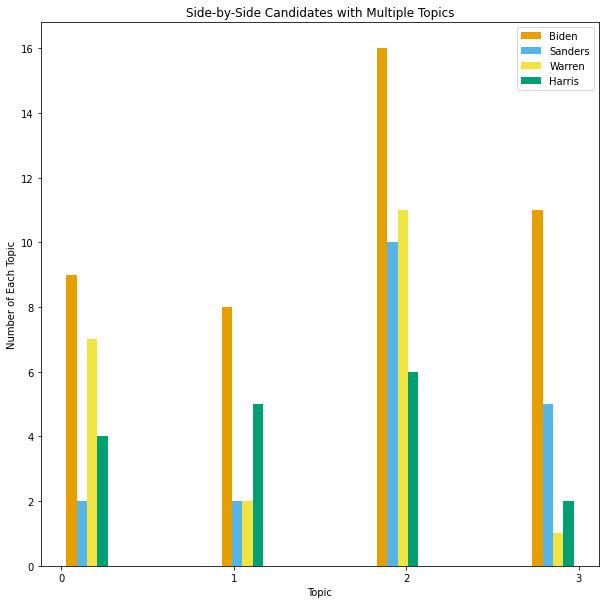

In [ ]:
# def filter_spk(data, name):
#   return data[data.speaker == name]

bd = list(final[final['speaker']== 'BIDEN']['topic'])
#bd.topic.value_counts().to_frame()
sd = list(final[final['speaker']== 'SANDERS']['topic'])
wn = list(final[final['speaker']== 'WARREN']['topic'])
hs = list(final[final['speaker'] == 'HARRIS']['topic'])

colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73']
names = ['Biden', 'Sanders','Warren', 'Harris']

plt.hist([bd, sd, wn, hs], color = colors, label=names)
bars = ('0', '1', '2', '3')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars)
# Plot formatting
plt.legend()
plt.xlabel('Topic')
plt.ylabel('Number of Each Topic')
plt.title('Side-by-Side Candidates with Multiple Topics')
plt.gcf().set_size_inches(10,10)

# Semantic Analysis

In [ ]:
from textblob import TextBlob
TextBlob('Fewer people are dying everyday').sentiment.polarity
spk['polarity'] = spk.text.apply(lambda x: TextBlob(x).polarity)
spk['subjectivity'] = spk.text.apply(lambda x: TextBlob(x).subjectivity)

x = []
name2 = ['BIDEN', 'BOOKER	', 'BUTTIGIEG', 'CASTRO', 'HARRIS', 'KLOBUCHAR', 'O¡¯ROURKE', 'SANDERS', 'WARREN', 'YANG']
for i in name2:
  polarity_score = spk[spk['speaker'] == i].polarity.mean()
  x.append(polarity_score)

p_score = pd.DataFrame(x)
p_name = pd.DataFrame(name2)
df_p = pd.concat([p_name, p_score], axis = 1)
df_p.columns = ['name', 'polarity_score_mean']

x = []
name2 = ['BIDEN', 'BOOKER	', 'BUTTIGIEG', 'CASTRO', 'HARRIS', 'KLOBUCHAR', 'O¡¯ROURKE', 'SANDERS', 'WARREN', 'YANG']
for i in name2:
  subjectivity_score = spk[spk['speaker'] == i].subjectivity.mean()
  x.append(subjectivity_score)

s_score = pd.DataFrame(x)
s_name = pd.DataFrame(name2)
df_s = pd.concat([s_name, s_score], axis = 1)
df_s.columns = ['name', 'subjectivity_score_mean']

#merge df_s df_p and poll
df1 = df_s.merge(df_p, left_on = 'name', right_on = 'name', how = 'inner')
df2 = df1.merge(poll, left_on = 'name', right_on = 'Name', how = 'inner')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Polarity score and Subjectivity score distribution 

Text(0, 0.5, 'subjectivity Score')

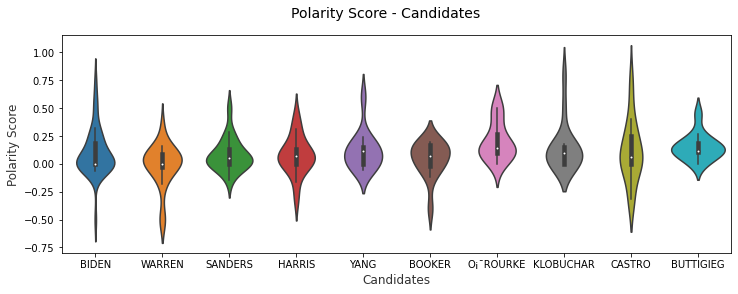

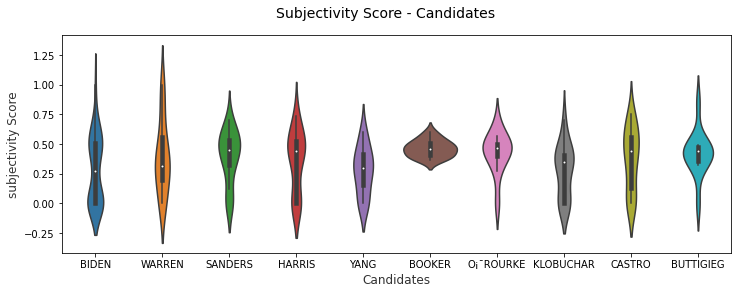

In [ ]:
# Violin Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Polarity Score - Candidates', fontsize=14)
 
sns.violinplot(x="speaker", y="polarity", data=final,  ax=ax)
ax.set_xlabel("Candidates",size = 12,alpha=0.8)
ax.set_ylabel("Polarity Score",size = 12,alpha=0.8)

# Violin Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Subjectivity Score - Candidates', fontsize=14)
 
sns.violinplot(x="speaker", y="subjectivity", data=final,  ax=ax)
ax.set_xlabel("Candidates",size = 12,alpha=0.8)
ax.set_ylabel("subjectivity Score",size = 12,alpha=0.8)

In [ ]:
df2

,name,subjectivity_score_mean,polarity_score_mean,Name,poll
0,BIDEN,0.286362,0.102625,BIDEN,0.268
1,BUTTIGIEG,0.423735,0.153625,BUTTIGIEG,0.048
2,CASTRO,0.372084,0.111486,CASTRO,0.010
3,HARRIS,0.356190,0.075272,HARRIS,0.065
4,KLOBUCHAR,0.278238,0.146477,KLOBUCHAR,0.012
5,O¡¯ROURKE,0.427875,0.201075,O¡¯ROURKE,0.028
6,SANDERS,0.395614,0.081720,SANDERS,0.173
7,WARREN,0.391154,-0.013052,WARREN,0.168
8,YANG,0.275756,0.117399,YANG,0.030


### Subjectivity_score_mean and Polarity_score_mean with Scatter Plots croessponding the Poll results

Text(0.5, 0, 'poll')

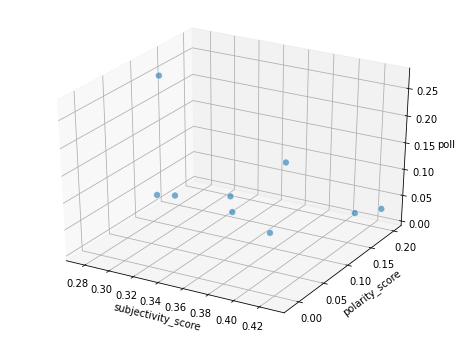

In [ ]:

# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
# name = np.array(['BIDEN', 'BOOKER	', 'BUTTIGIEG', 'CASTRO', 'HARRIS', 'KLOBUCHAR', 'O¡¯ROURKE', 'SANDERS', 'WARREN', 'YANG'])
xs = df2['subjectivity_score_mean']
ys = df2['polarity_score_mean']
zs = df2['poll']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w', )
# for i in range(len(name)):
#     plt.annotate(name[i], (sent_poll['precentage'][i], sent_poll['poll'][i]))
ax.set_xlabel('subjectivity_score')
ax.set_ylabel('polarity_score')
ax.set_zlabel('poll')
# Biden is the highest point 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


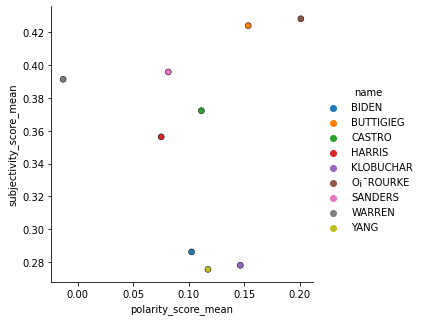

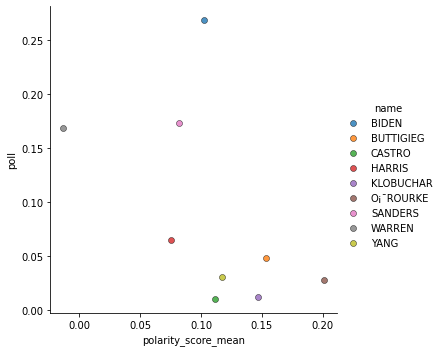

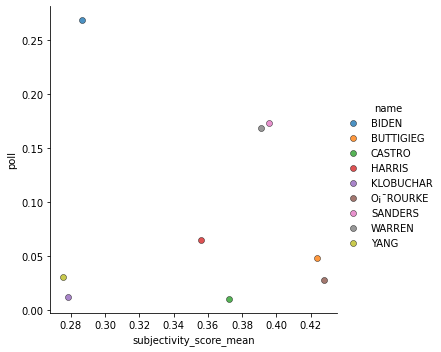

In [ ]:

# Visualizing 3-D mix data using scatter plots
# leveraging the concepts of hue for categorical dimension
jp = sns.pairplot(df2, x_vars=['polarity_score_mean'], y_vars=['subjectivity_score_mean'], size=4.5,
                  hue="name", 
                  plot_kws=dict(edgecolor="k", linewidth=0.5))
 
# we can also view relationships\correlations as needed                  
lp = sns.lmplot(x='polarity_score_mean', y='poll', hue='name', 
                #palette={"red": "#FF9999", "white": "#FFE888"},
                data=df2, fit_reg=True, legend=True,
                scatter_kws=dict(edgecolor="k", linewidth=0.5))   
up =  sns.lmplot(x='subjectivity_score_mean', y='poll', hue='name', 
                #palette={"red": "#FF9999", "white": "#FFE888"},
                data=df2, fit_reg=True, legend=True,
                scatter_kws=dict(edgecolor="k", linewidth=0.5))   

In [ ]:
final.head(3)

,speaker,text,num_sents,cleaned_text,stem_words,stem_sent,words,polarity,subjectivity,topic
0,BIDEN,I will be a president for every American.,1,I will be a president for every american,"[presid, everi, american]",presid everi american,"[I, will, be, a, president, for, every, american]",0.0,0.000,1
1,WARREN,This is our moment.,1,this be our moment,[moment],moment,"[this, be, our, moment]",0.0,0.000,2
2,SANDERS,We are in a struggle for the future of this co...,1,we be in a struggle for the future of this cou...,"[struggl, futur, countri]",struggl futur countri,"[we, be, in, a, struggle, for, the, future, of...",0.0,0.125,3


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


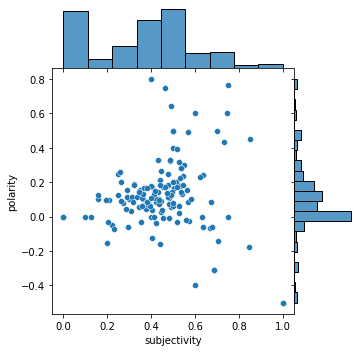

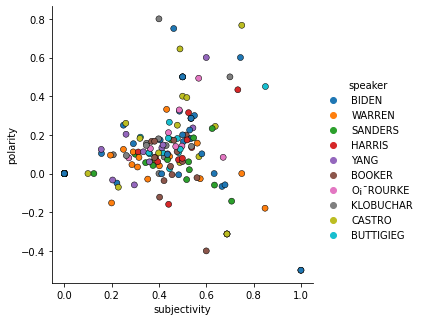

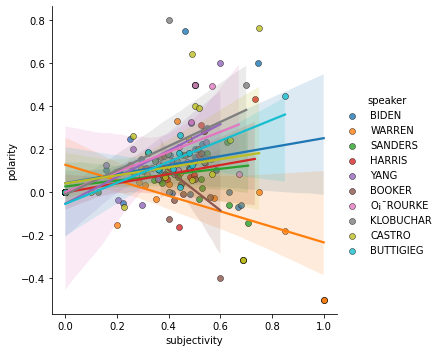

In [ ]:
# Joint Plot
j1 = sns.jointplot(x='subjectivity', y='polarity', data=final,
                    space=0, size=5, ratio=4)

jp = sns.pairplot(final, x_vars=["subjectivity"], y_vars=["polarity"], size=4.5,
                  hue="speaker", 
                  plot_kws=dict(edgecolor="k", linewidth=0.5))

# the overall distribution 
up =  sns.lmplot(x='subjectivity', y='polarity', hue='speaker', 
                #palette={"red": "#FF9999", "white": "#FFE888"},
                data=final,  legend=True,
                scatter_kws=dict(edgecolor="k", linewidth=0.5))   

In [ ]:
spk.head()

,speaker,text,num_sents,cleaned_text,stem_words,stem_sent,words
1,BIDEN,I will be a president for every American.,1,I will be a president for every american,"[presid, everi, american]",presid everi american,"[I, will, be, a, president, for, every, american]"
2,WARREN,This is our moment.,1,this be our moment,[moment],moment,"[this, be, our, moment]"
3,SANDERS,We are in a struggle for the future of this co...,1,we be in a struggle for the future of this cou...,"[struggl, futur, countri]",struggl futur countri,"[we, be, in, a, struggle, for, the, future, of..."
4,HARRIS,We fight for our country. That's the nature of...,2,we fight for our country that be the nature of...,"[fight, countri, natur]",fight countri natur,"[we, fight, for, our, country, that, be, the, ..."
5,SANDERS,Right now we can act.,1,right now we can act,"[right, act]",right act,"[right, now, we, can, act]"


In [ ]:
# Get sentiment score for each review
vader_sentiment = SentimentIntensityAnalyzer()
spk['scores_VADER'] = spk['text'].apply(lambda s: vader_sentiment.polarity_scores(s)['compound'])

# Predict sentiment label for each review
#amz_review['pred_VADER'] = amz_review['scores_VADER'].apply(lambda x: 1 if x >=0 else 0)
#amz_review.head()

In [ ]:
spk

,speaker,text,num_sents,cleaned_text,stem_words,stem_sent,words,scores_flair,pred_flair,polarity,subjectivity,scores_VADER
0,BIDEN,I will be a president for every American.,1,I will be a president for every american,"[presid, everi, american]",presid everi american,"[I, will, be, a, president, for, every, american]",0.998105,POSITIVE,0.000000,0.000000,0.0000
1,WARREN,This is our moment.,1,this be our moment,[moment],moment,"[this, be, our, moment]",0.982128,POSITIVE,0.000000,0.000000,0.0000
2,SANDERS,We are in a struggle for the future of this co...,1,we be in a struggle for the future of this cou...,"[struggl, futur, countri]",struggl futur countri,"[we, be, in, a, struggle, for, the, future, of...",0.995285,NEGATIVE,0.000000,0.125000,-0.3182
3,HARRIS,We fight for our country. That's the nature of...,2,we fight for our country that be the nature of...,"[fight, countri, natur]",fight countri natur,"[we, fight, for, our, country, that, be, the, ...",0.993981,POSITIVE,0.000000,0.000000,-0.3818
4,SANDERS,Right now we can act.,1,right now we can act,"[right, act]",right act,"[right, now, we, can, act]",0.998684,POSITIVE,0.285714,0.535714,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
184,YANG,I was an unhappy lawyer for five whole months...,12,I be an unhappy lawyer for five whole month a...,"[unhappi, lawyer, five, whole, month, leav, st...",unhappi lawyer five whole month leav start bus...,"[I, be, an, unhappy, lawyer, for, five, whole,...",0.998517,NEGATIVE,-0.058687,0.296111,0.9169
185,BOOKER,So my biggest professional setback is embarra...,23,so my big professional setback be embarrassin...,"[big, profession, setback, embarrass, lot, fol...",big profession setback embarrass lot folk bunc...,"[so, my, big, professional, setback, be, embar...",0.984381,NEGATIVE,0.082605,0.381494,0.6310
186,O¡¯ROURKE,"Thank you, George. Everything that I've learn...",13,thank you george everything that I ve learn a...,"[thank, georg, everyth, learn, resili, learn, ...",thank georg everyth learn resili learn hometow...,"[thank, you, george, everything, that, I, ve, ...",0.991857,POSITIVE,0.129592,0.363776,-0.9381
187,KLOBUCHAR,Thank you. My challenges and resilience have ...,16,thank you my challenge and resilience have br...,"[thank, challeng, resili, bring, grow, dad, st...",thank challeng resili bring grow dad struggl a...,"[thank, you, my, challenge, and, resilience, h...",0.997986,POSITIVE,0.145586,0.346793,0.9804


In [ ]:
spk.scores_VADER.describe()

count    189.000000
mean       0.220779
std        0.592228
min       -0.997100
25%        0.000000
50%        0.089700
75%        0.793500
max        0.992100
Name: scores_VADER, dtype: float64

In [ ]:
# Define a function to get Flair sentiment prediction score
def score_flair(text):
  sentence = Sentence(text)
  classifier.predict(sentence)
  score = sentence.labels[0].score
  value = sentence.labels[0].value
  return score, value

In [ ]:
# Get sentiment score for each review
spk['scores_flair'] = spk['cleaned_text'].apply(lambda s: score_flair(s)[0])

In [ ]:
# Predict sentiment label for each review
spk['pred_flair'] = spk['text'].apply(lambda s: score_flair(s)[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
spk.scores_flair.describe()

count    189.000000
mean       0.894848
std        0.141392
min        0.510432
25%        0.845734
50%        0.968293
75%        0.994558
max        0.999975
Name: scores_flair, dtype: float64

In [ ]:
spk.to_csv('spk.csv')

In [ ]:
final

,speaker,text,num_sents,cleaned_text,stem_words,stem_sent,words,scores_flair,pred_flair,polarity,subjectivity,topic
0,BIDEN,I will be a president for every American.,1,I will be a president for every american,"[presid, everi, american]",presid everi american,"[I, will, be, a, president, for, every, american]",0.997806,POSITIVE,0.000000,0.000000,2
1,WARREN,This is our moment.,1,this be our moment,[moment],moment,"[this, be, our, moment]",0.995481,POSITIVE,0.000000,0.000000,0
2,SANDERS,We are in a struggle for the future of this co...,1,we be in a struggle for the future of this cou...,"[struggl, futur, countri]",struggl futur countri,"[we, be, in, a, struggle, for, the, future, of...",0.993857,NEGATIVE,0.000000,0.125000,3
3,HARRIS,We fight for our country. That's the nature of...,2,we fight for our country that be the nature of...,"[fight, countri, natur]",fight countri natur,"[we, fight, for, our, country, that, be, the, ...",0.997053,POSITIVE,0.000000,0.000000,0
4,SANDERS,Right now we can act.,1,right now we can act,"[right, act]",right act,"[right, now, we, can, act]",0.999276,POSITIVE,0.285714,0.535714,2
...,...,...,...,...,...,...,...,...,...,...,...,...
184,YANG,I was an unhappy lawyer for five whole months...,12,I be an unhappy lawyer for five whole month a...,"[unhappi, lawyer, five, whole, month, leav, st...",unhappi lawyer five whole month leav start bus...,"[I, be, an, unhappy, lawyer, for, five, whole,...",0.999886,NEGATIVE,-0.058687,0.296111,2
185,BOOKER,So my biggest professional setback is embarra...,23,so my big professional setback be embarrassin...,"[big, profession, setback, embarrass, lot, fol...",big profession setback embarrass lot folk bunc...,"[so, my, big, professional, setback, be, embar...",0.795190,NEGATIVE,0.082605,0.381494,0
186,O¡¯ROURKE,"Thank you, George. Everything that I've learn...",13,thank you george everything that I ve learn a...,"[thank, georg, everyth, learn, resili, learn, ...",thank georg everyth learn resili learn hometow...,"[thank, you, george, everything, that, I, ve, ...",0.985087,POSITIVE,0.129592,0.363776,2
187,KLOBUCHAR,Thank you. My challenges and resilience have ...,16,thank you my challenge and resilience have br...,"[thank, challeng, resili, bring, grow, dad, st...",thank challeng resili bring grow dad struggl a...,"[thank, you, my, challenge, and, resilience, h...",0.996040,POSITIVE,0.145586,0.346793,0


In [ ]:
final.subjectivity.describe()

count    189.000000
mean       0.353974
std        0.246369
min        0.000000
25%        0.125000
50%        0.402778
75%        0.517083
max        1.000000
Name: subjectivity, dtype: float64